# Advances validation
The OBB model is trained as a 9-class classifier but ultimately designed to differentiate only two superclasses: *Anthophila* and non-*Anthophila*.

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
from matplotlib.patches import Rectangle
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [7]:
CURR_TRAIN = "train36"
model = YOLO(f"runs/obb/{CURR_TRAIN}/weights/best.pt")
labels = model.names
unsupported = {8, 9}
THRESHOLD = 0.65
print([labels[idx] for idx in list(unsupported)])

['Syrphidae', 'Vespidae']


In [8]:
results = model.val(conf=THRESHOLD)

Ultralytics 8.3.158  Python-3.12.10 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3080, 10239MiB)
YOLO11s-obb summary (fused): 109 layers, 9,702,657 parameters, 0 gradients, 22.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1484.5614.9 MB/s, size: 942.0 KB)


val: Scanning E:\Jetbrains IDE Projects\Uni\BeeClassifier\data\in-bucket\labels.cache... 460 images, 12 backgrounds, 0 corrupt: 100%|██████████| 460/460 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.72it/s]


                   all        460        460      0.934      0.842      0.896      0.796
               Andrena         36         36      0.885      0.639      0.777      0.707
             Anthidium         23         23          1      0.739       0.87      0.745
                  Apis        123        126      0.947      0.992      0.981      0.875
                Bombus         81         83          1      0.916      0.958      0.848
              Halictus         53         53      0.922      0.887      0.904      0.798
               Hylaeus          6          6          1          1      0.995      0.932
          Lasioglossum         19         23       0.76      0.826      0.802       0.69
                 Osmia         19         19      0.917      0.579      0.772      0.663
             Syrphidae         46         46      0.956      0.935      0.951      0.874
              Vespidae         44         45      0.953      0.911       0.95      0.824
Speed: 1.4ms preproce

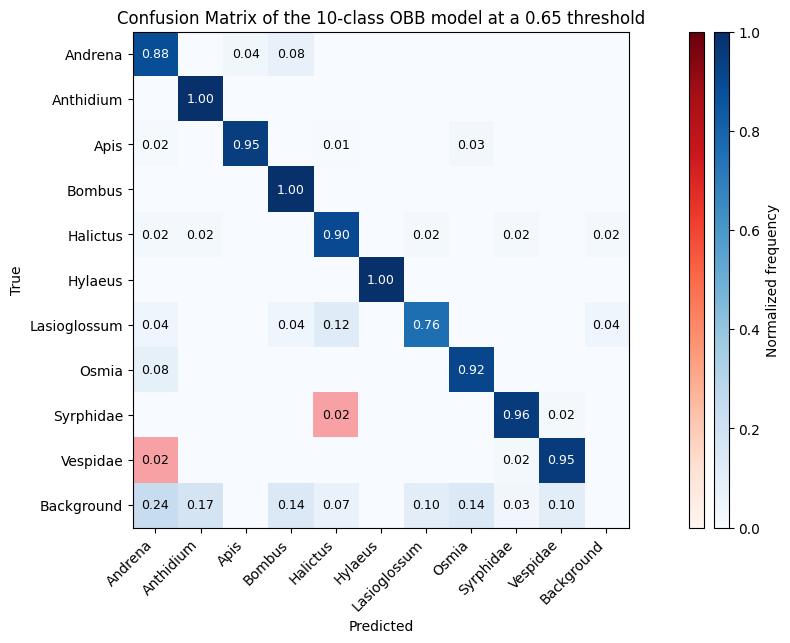

In [9]:
# Confusion matrix
cm = results.confusion_matrix.matrix.copy()
cm = cm / (cm.sum(axis=1, keepdims=True) + 1e-9)

labels = list(model.names.values()) + ["Background"]
fig, ax = plt.subplots(figsize=(8, 8))

# Plot confusion matrix
im = ax.imshow(cm, cmap="Blues")

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_yticklabels(labels)

ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title(f"Confusion Matrix of the {len(model.names)}-class OBB model at a {THRESHOLD} threshold")

# Highlight cross-superclass confusions in red
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i in unsupported and j not in unsupported and cm[i, j] > 0:
            if i != len(labels) - 1 and j != len(labels) - 1:
                ax.add_patch(
                    Rectangle(
                        (j - 0.5, i - 0.5),
                        1, 1,
                        facecolor="red",
                        alpha=0.35,
                        edgecolor=None
                    )
                )

# Switch text color to white at low values to maintain readability
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] > 0:
            ax.text(
                j, i,
                f"{cm[i, j]:.2f}",
                ha="center",
                va="center",
                color="white" if cm[i, j] > 0.3 else "black",
                fontsize=9,
            )

# Colorbar layout
divider = make_axes_locatable(ax)
cax_red = divider.append_axes("right", size="3%", pad=0.6)
red_mappable = ScalarMappable(
    norm=Normalize(vmin=0, vmax=1),
    cmap="Reds"
)
red_mappable.set_array([])

# Red colorbar
cb_red = fig.colorbar(red_mappable, cax=cax_red)
cb_red.set_ticks([])

# Blue colorbar
cax_blue = divider.append_axes("right", size="3%", pad=0.1)
cb_blue = fig.colorbar(im, cax=cax_blue)
cb_blue.set_label("Normalized frequency", rotation=90)
plt.tight_layout()
plt.show()

In [10]:
background_idx = 0
superclass_A = list(unsupported)
superclass_B = [i for i in range(cm.shape[0]) if i not in superclass_A and i != background_idx]

def precision_recall(cm, positive_indices):
    # True positives
    TP = cm[np.ix_(positive_indices, positive_indices)].sum()
    # False negatives
    FN = cm[positive_indices, :].sum() - TP
    # False positives
    FP = cm[:, positive_indices].sum() - TP
    # Precision and recall
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    return precision, recall

prec_A, rec_A = precision_recall(cm, superclass_A)
prec_B, rec_B = precision_recall(cm, superclass_B)

print(f"Superclass A (Un-supported): Precision={prec_A:.4f}, Recall={rec_A:.4f}")
print(f"Superclass B (Supported): Precision={prec_B:.4f}, Recall={rec_B:.4f}")

Superclass A (Un-supported): Precision=0.9254, Recall=0.9773
Superclass B (Supported): Precision=0.9818, Recall=0.9304
